In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=06db8089ba623cd057bcb0a307215ad8a5d897917f961e71a6430b5d4300182f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession


In [4]:
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .getOrCreate()


In [5]:
data = spark.read.csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', header=False, inferSchema=True)


In [6]:
data.show(5, truncate=False)

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|_c0|_c1       |_c2                         |_c3     |_c4            |_c5                                                                                                                |
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0  |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0  |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0  |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus   

In [7]:
data = data.selectExpr("_c0 as target", "_c5 as text")


In [9]:
data.show(5, truncate=False)

+------+-------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                               |
+------+-------------------------------------------------------------------------------------------------------------------+
|0     |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0     |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|0     |my whole body feels itchy and like its on fire                                                                     |
|0     |@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     |


In [8]:
data.count()

1600000

Drop null values 

In [ ]:
data = data.dropna()
data.count()


1600000

Drop duplicates

In [ ]:
data.dropDuplicates()
data.count()


1600000

word cloud for positive tweets 


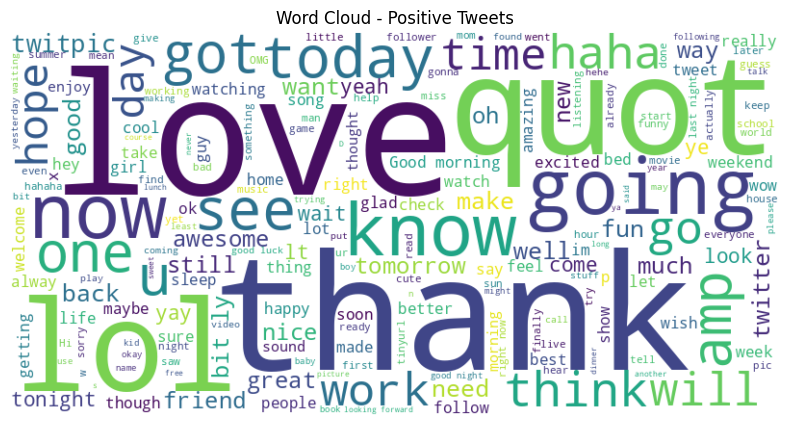

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word cloud for most frequent words
positive_Tweets = data.filter(data["target"] == 4)
negative_Tweets = data.filter(data["target"] == 0)

positive_words = " ".join(positive_Tweets.select("text").rdd.flatMap(lambda x: x).collect())
negative_words = " ".join(negative_Tweets.select("text").rdd.flatMap(lambda x: x).collect())

# Create word cloud for positive Tweets
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Word Cloud - Positive Tweets")
plt.axis("off")
plt.show()


word cloud of negative Tweets

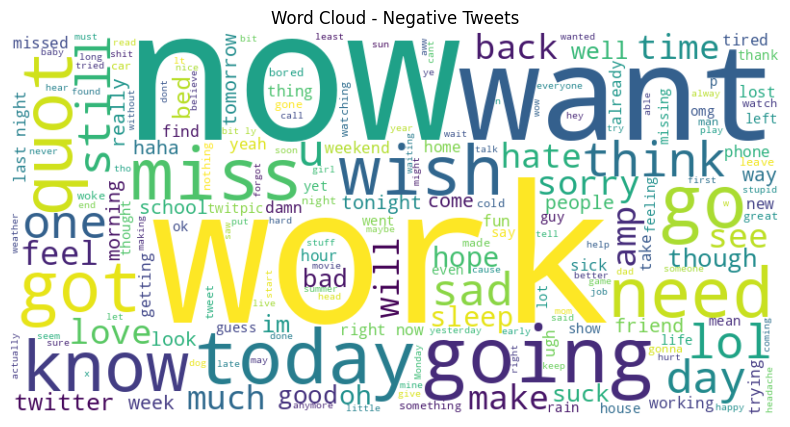

In [11]:
wordcloud_negative = WordCloud(width=800, height=400, background_color="white").generate(negative_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Word Cloud - Negative Tweets")
plt.axis("off")
plt.show()

Bar chart for the distribution of sentiment

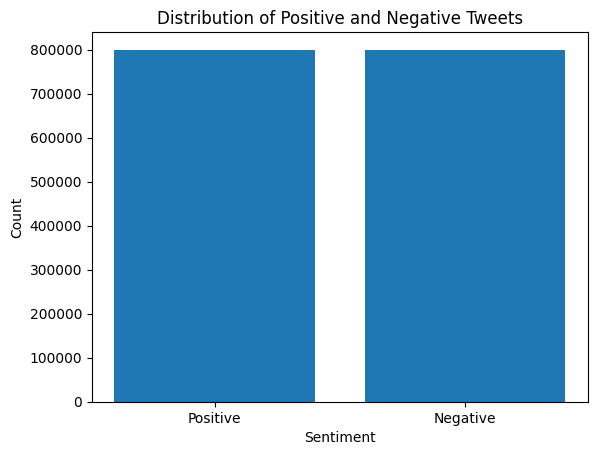

In [12]:
positive_count = positive_Tweets.count()
negative_count = negative_Tweets.count()

labels = ["Positive", "Negative"]
counts = [positive_count, negative_count]

plt.bar(labels, counts)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Positive and Negative Tweets")
plt.show()

svm with stemming

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import ArrayType, StringType

from pyspark.sql.functions import udf

# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))


# Define a function for stemming using SnowballStemmer from NLTK
stemmer = SnowballStemmer(language='english')

# Tokenization
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W")
tokenized_data = tokenizer.transform(data)

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stopwords_remover.transform(tokenized_data)

# Apply stemming using Snowball stemmer
stemming_udf = udf(lambda words: [stemmer.stem(word) for word in words], ArrayType(StringType()))
stemmed_data = filtered_data.withColumn("stemmed_words", stemming_udf("filtered_words"))

# Convert the stemmed words into numerical features using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="stemmed_words", outputCol="features")
vectorized_data = count_vectorizer.fit(stemmed_data).transform(stemmed_data)

# Convert the target labels to numerical format
label_indexer = StringIndexer(inputCol="target", outputCol="label")
indexed_data = label_indexer.fit(vectorized_data).transform(vectorized_data)

# Split the dataset into training and testing sets
trainData, testData = indexed_data.randomSplit([0.8, 0.2], seed=42)

# Create a Support Vector Machine (SVM) classifier
svm = LinearSVC(featuresCol="features", labelCol="label", predictionCol="prediction")

# Fit the SVM model on the training data
model = svm.fit(trainData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 76.51%


Naive bayes with stemming

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from nltk.stem.snowball import SnowballStemmer

# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))


# Define a function for stemming using SnowballStemmer from NLTK
stemmer = SnowballStemmer(language='english')

# Tokenization
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W")
tokenized_data = tokenizer.transform(data)

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stopwords_remover.transform(tokenized_data)

# Apply stemming using Snowball stemmer
stemming_udf = udf(lambda words: [stemmer.stem(word) for word in words], ArrayType(StringType()))
stemmed_data = filtered_data.withColumn("stemmed_words", stemming_udf("filtered_words"))

# Convert the stemmed words into numerical features using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="stemmed_words", outputCol="features")
vectorized_data = count_vectorizer.fit(stemmed_data).transform(stemmed_data)

# Convert the target labels to numerical format
label_indexer = StringIndexer(inputCol="target", outputCol="label")
indexed_data = label_indexer.fit(vectorized_data).transform(vectorized_data)

# Split the dataset into training and testing sets
trainData, testData = indexed_data.randomSplit([0.8, 0.2], seed=42)

# Create a Naive Bayes classifier
naive_bayes = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")

# Fit the Naive Bayes model on the training data
model = naive_bayes.fit(trainData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 76.71%


logistic with stemming

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from nltk.stem.snowball import SnowballStemmer


# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))

# Define a function for stemming using SnowballStemmer from NLTK
stemmer = SnowballStemmer(language='english')

# Tokenization
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W")
tokenized_data = tokenizer.transform(data)

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stopwords_remover.transform(tokenized_data)

# Apply stemming using Snowball stemmer
stemming_udf = udf(lambda words: [stemmer.stem(word) for word in words], ArrayType(StringType()))
stemmed_data = filtered_data.withColumn("stemmed_words", stemming_udf("filtered_words"))

# Convert the stemmed words into numerical features using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="stemmed_words", outputCol="features")
vectorized_data = count_vectorizer.fit(stemmed_data).transform(stemmed_data)

# Convert the target labels to numerical format
label_indexer = StringIndexer(inputCol="target", outputCol="label")
indexed_data = label_indexer.fit(vectorized_data).transform(vectorized_data)

# Split the dataset into training and testing sets
trainData, testData = indexed_data.randomSplit([0.8, 0.2], seed=42)

# Create a Logistic Regression classifier
logistic_regression = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction")

# Fit the Logistic Regression model on the training data
model = logistic_regression.fit(trainData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 75.95%


svm without stemming 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))


# Define the tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W")
tokenized_data = tokenizer.transform(data)

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stopwords_remover.transform(tokenized_data)

# Convert the filtered words into numerical features using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vectorized_data = count_vectorizer.fit(filtered_data).transform(filtered_data)

# Convert the target labels to numerical format
label_indexer = StringIndexer(inputCol="target", outputCol="label")
indexed_data = label_indexer.fit(vectorized_data).transform(vectorized_data)

# Split the dataset into training and testing sets
trainData, testData = indexed_data.randomSplit([0.8, 0.2], seed=42)

# Create a Support Vector Machine (SVM) classifier
svm = LinearSVC(featuresCol="features", labelCol="label", predictionCol="prediction")

# Fit the SVM model on the training data
model = svm.fit(trainData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 77.16%


logistic without stemming 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))


# Define the tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W")
tokenized_data = tokenizer.transform(data)

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stopwords_remover.transform(tokenized_data)

# Convert the filtered words into numerical features using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vectorized_data = count_vectorizer.fit(filtered_data).transform(filtered_data)

# Convert the target labels to numerical format
label_indexer = StringIndexer(inputCol="target", outputCol="label")
indexed_data = label_indexer.fit(vectorized_data).transform(vectorized_data)

# Split the dataset into training and testing sets
trainData, testData = indexed_data.randomSplit([0.8, 0.2], seed=42)

# Create a Logistic Regression classifier
logistic_regression = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction")

# Fit the Logistic Regression model on the training data
model = logistic_regression.fit(trainData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 75.98%


naive bayes without stemming

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, regexp_replace, lower, trim



# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))

# Tokenization
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W")
tokenized_data = tokenizer.transform(data)

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stopwords_remover.transform(tokenized_data)

# Create a HashingTF instance to convert words to numerical features
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features")
featurized_data = hashing_tf.transform(filtered_data)

# Create an IDF instance to scale the feature frequencies
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
vectorized_data = idf_model.transform(featurized_data)

# Convert the target labels to numerical format
label_indexer = StringIndexer(inputCol="target", outputCol="label")
indexed_data = label_indexer.fit(vectorized_data).transform(vectorized_data)

# Split the dataset into training and testing sets
trainData, testData = indexed_data.randomSplit([0.8, 0.2], seed=42)

# Create a Naive Bayes classifier
naive_bayes = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")

# Train the Naive Bayes model
model = naive_bayes.fit(trainData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 73.84%


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, regexp_replace, lower, trim
from pyspark.ml import Pipeline

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))

# Create a pipeline
pipeline = Pipeline(stages=[
    RegexTokenizer(inputCol="text", outputCol="words", pattern=r"\W"),
    StopWordsRemover(inputCol="words", outputCol="filtered_words"),
    CountVectorizer(inputCol="filtered_words", outputCol="features"),
    StringIndexer(inputCol="target", outputCol="label"),
    NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")
])

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Train the pipeline
model = pipeline.fit(trainData)

# Save the trained model
model.save("/content/sample_data/nbtest2.pickle")
print('Model Saved')

# Make predictions on the testing data
predictions = model.transform(testData)


# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Model Saved
Accuracy: 77.18%


checking sentiment of text using the trained Naive Bayes (without stemming) model

In [ ]:
from pyspark.ml.classification import NaiveBayesModel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql.functions import col, regexp_replace, lower, trim
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the saved Naive Bayes model
loadedModel = PipelineModel.load("/content/sample_data/nbtest2.pickle")

# Assuming you have a new text provided by the user
user_text = "text to clssify"

# Create a DataFrame with the user text
data = spark.createDataFrame([(user_text,)], ["text"])

# Data cleaning
data = data.withColumn("text", regexp_replace(col("text"), "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+", ""))
data = data.withColumn("text", lower(col("text")))
data = data.withColumn("text", trim(col("text")))

# Tokenization
tokenizer = RegexTokenizer(inputCol="text", outputCol="words_temp", pattern=r"\W")
tokenized_data = tokenizer.transform(data).drop("words")

# Rename the temporary column to "words"
tokenized_data = tokenized_data.withColumnRenamed("words_temp", "words")

# Remove stopwords from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_temp")
filtered_data = stopwords_remover.transform(tokenized_data).drop("filtered_words")

# Rename the temporary column to "filtered_words"
filtered_data = filtered_data.withColumnRenamed("filtered_words_temp", "filtered_words")

# Convert the filtered words into numerical features using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vectorized_data = count_vectorizer.fit(filtered_data).transform(filtered_data)

# Make predictions using the loaded model
predictions = loadedModel.transform(vectorized_data.select(['text']))

# Show the predicted labels
predictions.show()


+---------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+
|           text|              words| filtered_words|            features|       rawPrediction|         probability|prediction|
+---------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+
|text to clssify|[text, to, clssify]|[text, clssify]|(262144,[482],[1.0])|[-8.7129635717716...|[0.51927696967051...|       0.0|
+---------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+

